### Imports

In [5]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram
from typing import List, Tuple
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer,RecursiveMinimumEigenOptimizer,SolutionSample,OptimizationResultStatus
from qiskit_optimization.translators import from_docplex_mp
from docplex.mp.model import Model
import numpy as np
import matplotlib
import random
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from scipy.optimize import minimize
import rustworkx as rx
from rustworkx.visualization import mpl_draw

### Setting parameters

In [13]:
N = 2 # Number of doctors
M = 3 # Number of patients
W = [random.randint(5,30) for _ in range(M)]
k = 10000 # penalty parameter
i = 0 # dont touch

### Creating QUBO formula

In [14]:
model = Model()
decision = model.binary_var_matrix(N, M, name="x")

subsums = [model.sum(decision[i,l]*W[l] for l in range(M)) for i in range(N)]
main_obj = model.max(model.sum(subsums))

i = 0

st_kara = k*model.sum((1-model.sum(decision[i,j] for i in range(N)))**2 for j in range(M))


final = model.minimize(main_obj+st_kara)

model = from_docplex_mp(model)
hamiltonian, offset = model.to_ising()

print(hamiltonian)

ansatz = QAOAAnsatz(hamiltonian, reps=2)

SparsePauliOp(['IIIIIZ', 'IIZIII', 'IIIIZI', 'IZIIII', 'IIIZII', 'ZIIIII', 'IIZIIZ', 'IZIIZI', 'ZIIZII'],
              coeffs=[ -13. +0.j,  -13. +0.j,  -12. +0.j,  -12. +0.j,  -12.5+0.j,  -12.5+0.j,
 5000. +0.j, 5000. +0.j, 5000. +0.j])


# QUANTUM MACHINE

In [8]:
service = QiskitRuntimeService(channel="ibm_quantum",token="")

In [9]:
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_osaka'

In [10]:
def cost_func(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    cost = result[0].data.evs[0]
    return cost

In [11]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
hamiltonian_isa

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

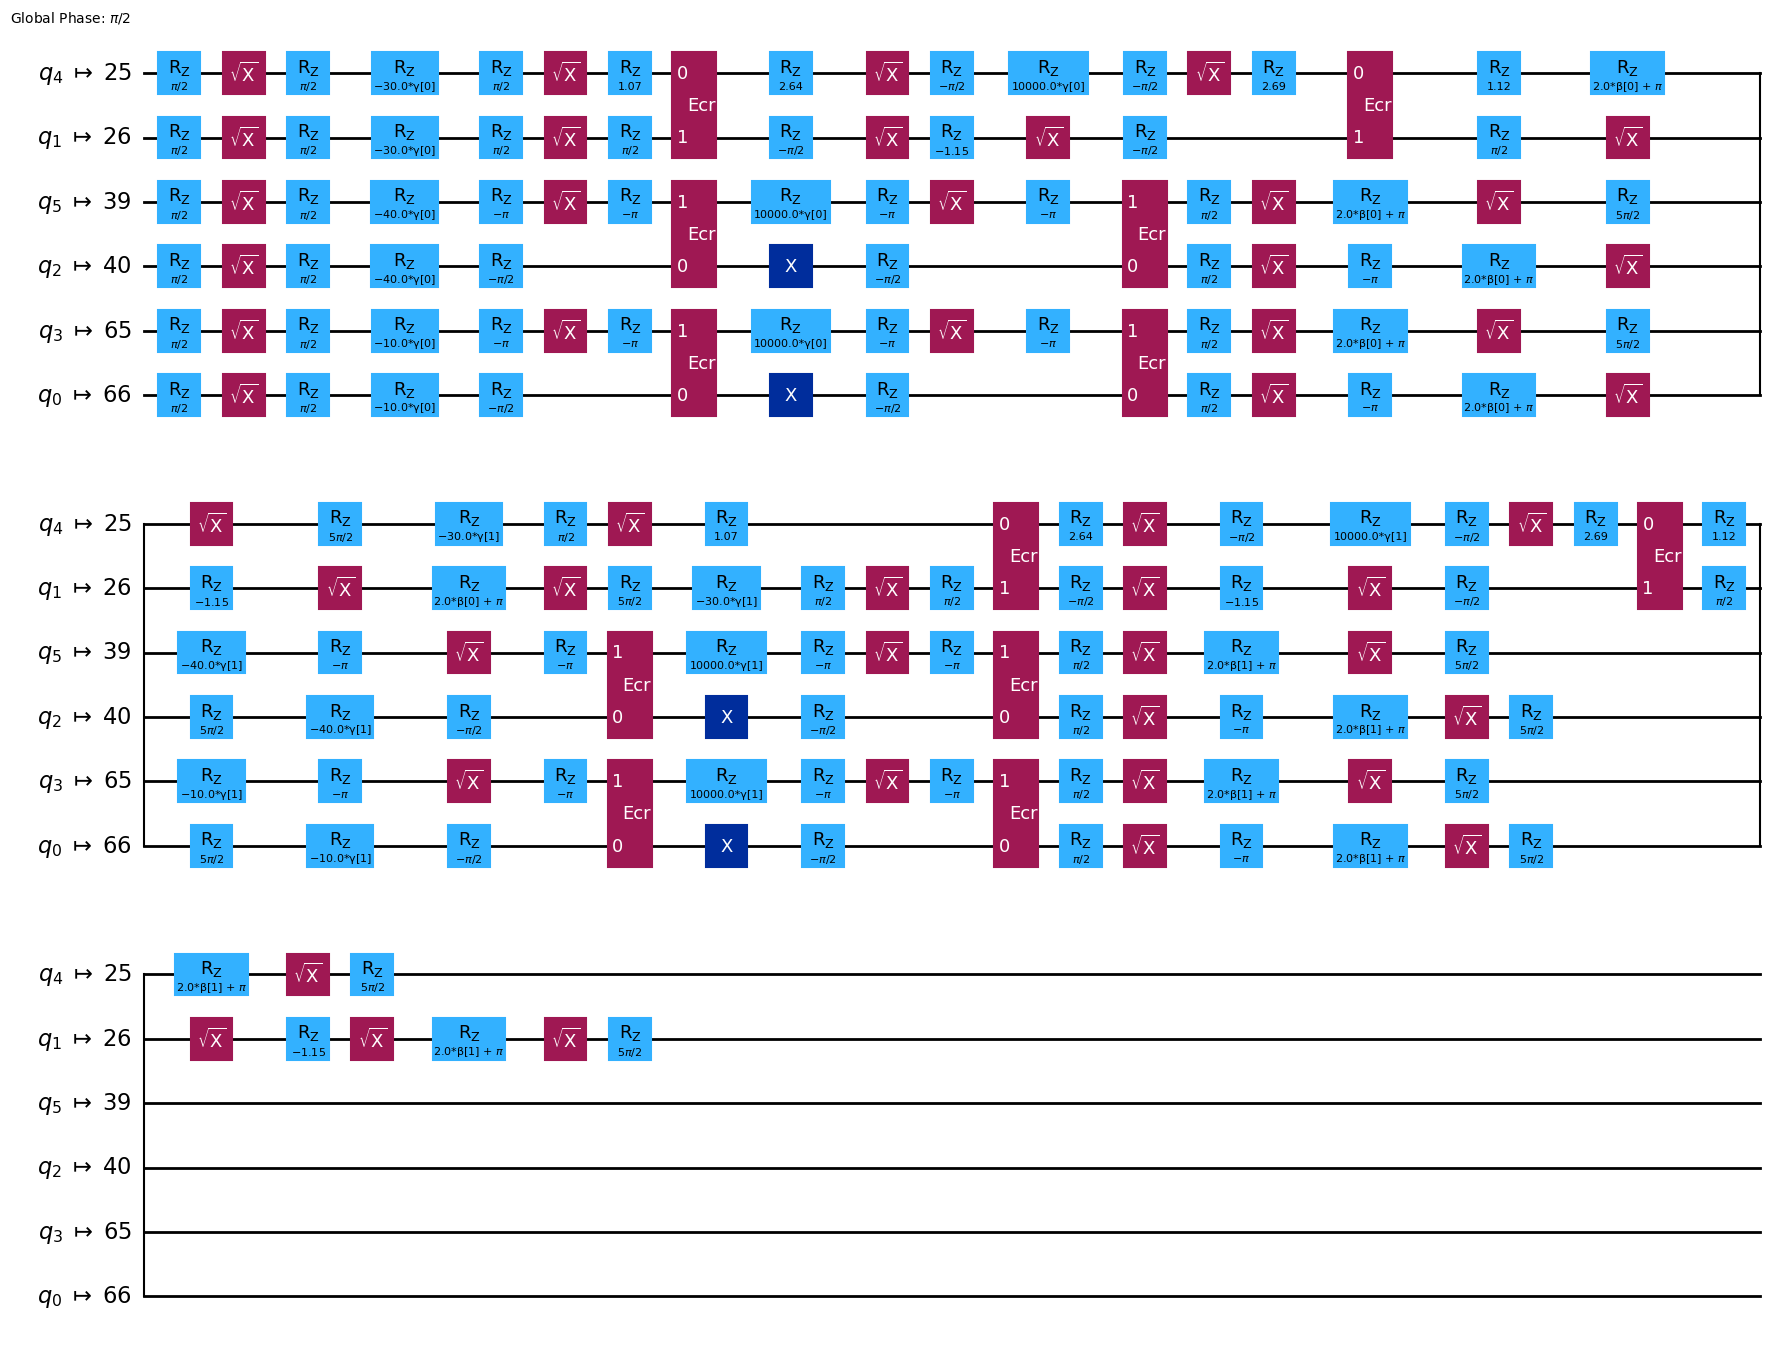

In [12]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")